import libraries and read data

In [ ]:
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal.git@landsat-dev

In [78]:
#import what is needed
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from datetime import datetime
from pathlib import Path
from shapely.geometry import box
from matplotlib import pyplot as plt
from shapely.geometry import Point

from eodal.config import get_settings
from eodal.core.sensors import Landsat
from eodal.core.scene import SceneCollection
from eodal.core.band import Band
from eodal.core.band import GeoInfo
from eodal.mapper.feature import Feature
from eodal.core.raster import RasterCollection

In [79]:
#read tif from disk:
fpath_raster = Path('S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_2022.tif')

#set the desired number of clusters
n_clusters = 7

#initialize a RasterCollection from the .tif file
composite = RasterCollection.from_multi_band_raster(fpath_raster=fpath_raster, band_aliases = ["blue", "green", "red", "nir_1", "swir"])

#calculate some SI for KMeans
composite.calc_si('NDVI', inplace = True)
composite.calc_si('EVI', inplace = True)

#show RasterCollection
composite

EOdal RasterCollection
----------------------
# Bands:    7
Band names:    blue_median, green_median, red_median, nir08_median, swir16_median, NDVI, EVI
Band aliases:    blue, green, red, nir_1, swir, ndvi, evi

Text(0.5, 1.0, 'NDVI')

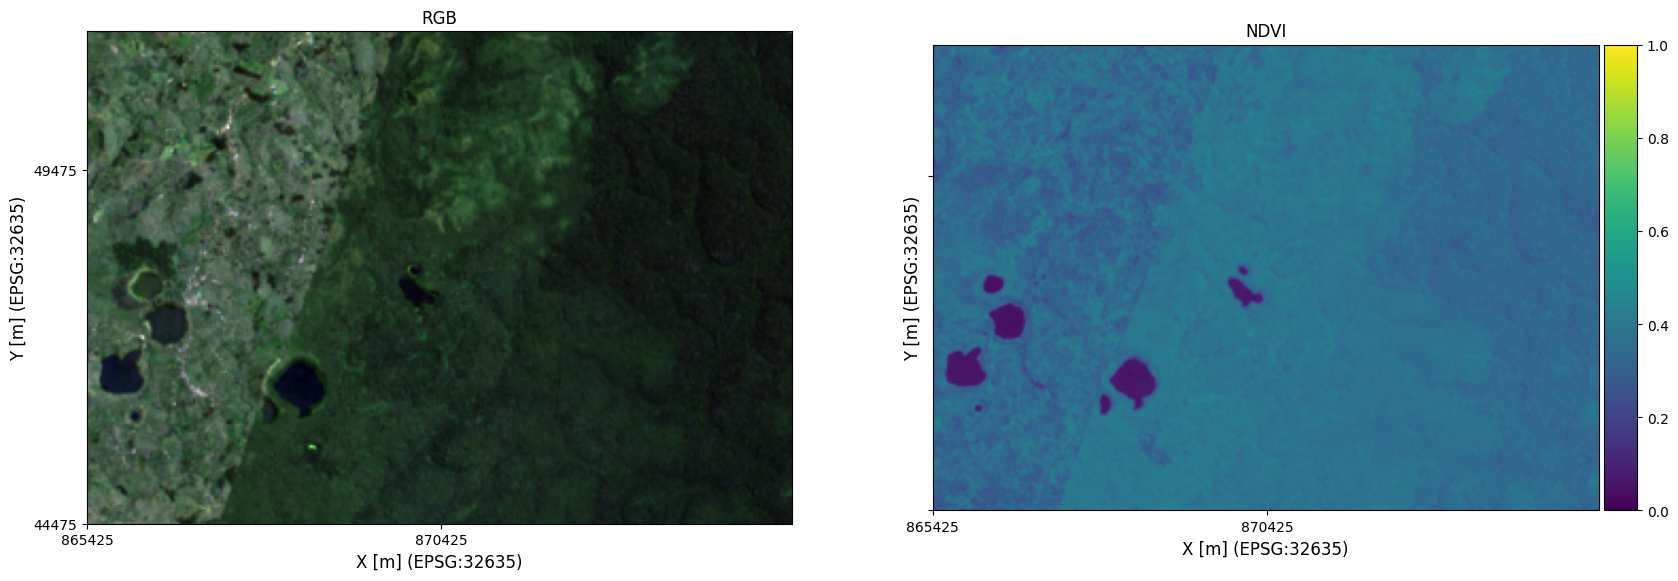

In [80]:
#Plot RGB and NDVI
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title("RGB")

composite.plot_band("NDVI", colormap="viridis", vmin=0, vmax=1, ax=axs[1])
axs[1].set_title("NDVI")

In [81]:
# Create a DataFrame from the RasterCollection
gdf = composite.to_dataframe()
display(gdf)

,geometry,blue_median,green_median,red_median,nir08_median,swir16_median,NDVI,EVI
0,POINT (865425.000 51435.000),0.08541,0.095620,0.091040,0.177420,0.144570,0.321761,0.199384
1,POINT (865425.000 51405.000),0.08468,0.094770,0.091310,0.180260,0.142820,0.327540,0.203450
2,POINT (865425.000 51375.000),0.08460,0.095025,0.089555,0.186080,0.143910,0.350191,0.221609
3,POINT (865425.000 51345.000),0.08451,0.096180,0.091165,0.180925,0.141635,0.329891,0.205102
4,POINT (865425.000 51315.000),0.08387,0.095195,0.090045,0.172990,0.137625,0.315338,0.191252
...,...,...,...,...,...,...,...,...
77019,POINT (875355.000 44625.000),0.07908,0.085175,0.081280,0.164545,0.116650,0.338717,0.196542
77020,POINT (875355.000 44595.000),0.07859,0.084990,0.080720,0.165220,0.116690,0.343580,0.199271
77021,POINT (875355.000 44565.000),0.07839,0.084860,0.080730,0.168720,0.115480,0.352736,0.206515
77022,POINT (875355.000 44535.000),0.07828,0.084040,0.080490,0.163300,0.113710,0.339678,0.195465


In [82]:
# Apply KMeans to the selected columns of the DataFrame
kmeans = KMeans(n_clusters = n_clusters, n_init=10, random_state = 42) 

# # Extract x and y coordinates into new columns
# gdf['x_coordinate'] = gdf['geometry'].apply(lambda point: Point(point).x)
# gdf['y_coordinate'] = gdf['geometry'].apply(lambda point: Point(point).y)

# Select all columns except the first one (geometry is non-numeric)
selected_columns = gdf.columns[1:]

#fit the model to the data
kmeans.fit(gdf[selected_columns])

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the DataFrame and show it
gdf['cluster_label'] = labels
gdf

,geometry,blue_median,green_median,red_median,nir08_median,swir16_median,NDVI,EVI,cluster_label
0,POINT (865425.000 51435.000),0.08541,0.095620,0.091040,0.177420,0.144570,0.321761,0.199384,1
1,POINT (865425.000 51405.000),0.08468,0.094770,0.091310,0.180260,0.142820,0.327540,0.203450,1
2,POINT (865425.000 51375.000),0.08460,0.095025,0.089555,0.186080,0.143910,0.350191,0.221609,5
3,POINT (865425.000 51345.000),0.08451,0.096180,0.091165,0.180925,0.141635,0.329891,0.205102,1
4,POINT (865425.000 51315.000),0.08387,0.095195,0.090045,0.172990,0.137625,0.315338,0.191252,1
...,...,...,...,...,...,...,...,...,...
77019,POINT (875355.000 44625.000),0.07908,0.085175,0.081280,0.164545,0.116650,0.338717,0.196542,6
77020,POINT (875355.000 44595.000),0.07859,0.084990,0.080720,0.165220,0.116690,0.343580,0.199271,6
77021,POINT (875355.000 44565.000),0.07839,0.084860,0.080730,0.168720,0.115480,0.352736,0.206515,5
77022,POINT (875355.000 44535.000),0.07828,0.084040,0.080490,0.163300,0.113710,0.339678,0.195465,6


In [83]:
# add column cluster_label as a new Band into the RasterCollection composite
cluster_label = Band.from_vector(vector_features = gdf,
                                 band_name_src = 'cluster_label',
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst='cluster_label')

composite.add_band(cluster_label)

Text(0.5, 1.0, 'Kmeans cluster')

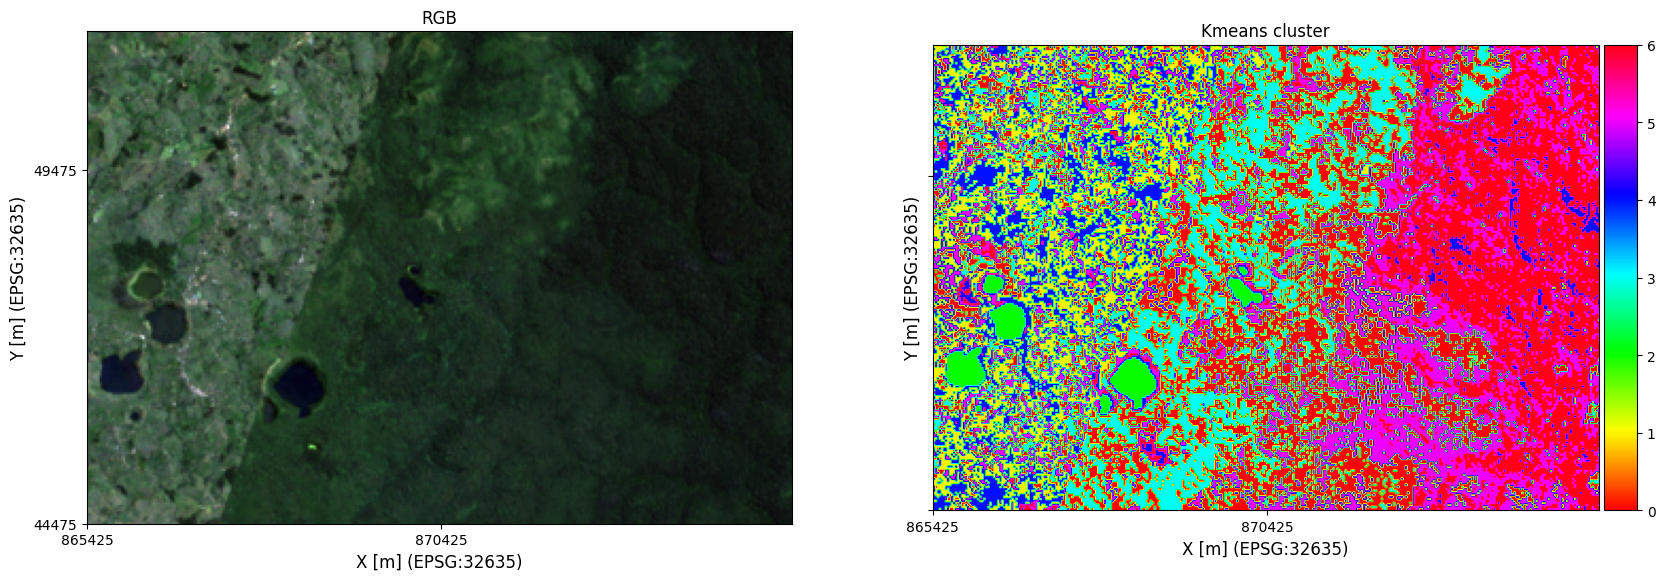

In [85]:
#Plot RGB and Label
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title("RGB")

composite.plot_band("cluster_label", colormap="hsv", ax=axs[1])
axs[1].set_title("Kmeans cluster")